In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import os
import transformers
from accelerate import Accelerator

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
accelerator = Accelerator()
device = accelerator.device

/Users/panda/anaconda3/envs/ts/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import ViTImageProcessor, ViTForImageClassification, ViTConfig
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

pretrained_name = 'google/vit-base-patch16-224'
config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)
pred_model = ViTForImageClassification.from_pretrained(pretrained_name)
pred_model.to(device)

inputs = processor(images=image, return_tensors="pt")
inputs.to(device)
outputs = pred_model(**inputs, output_hidden_states=True)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

Predicted class: Egyptian cat


In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks=5, bottleneck_dim=64):
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.layers = nn.ModuleList()
        for _ in range(num_blocks):
            shortcut_layers = []
            shortcut_layers.append(nn.Linear(hidden_dim, bottleneck_dim))
            shortcut_layers.append(nn.Dropout())
            shortcut_layers.append(nn.ReLU())  # Using ReLU for simplicity; you can choose other activations as needed
            shortcut_layers.append(nn.Linear(bottleneck_dim, hidden_dim))
            shortcut_layers.append(nn.Dropout())
            self.layers.append(nn.Sequential(*shortcut_layers))

        self.output_layer= nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.input_layer(x)
        for layer in self.layers:
            x = x + layer(x) # shortcut
        return self.output_layer(x)


def pairwise_cosine_similarity(Q, K):
    """
    Q: (N, d)
    K: (N, L, d)
    """
    attention_scores = torch.matmul(Q.unsqueeze(1), K.transpose(-2, -1)).squeeze(1) # [N, L]
    # denominator = torch.sqrt((Q**2).sum(-1).unsqueeze(-1) * (K**2).sum(-1).unsqueeze(-2))
    denominator = (K**2).sum(-1) # [N, L]
    attention_weights = attention_scores / (denominator + 1e-5)
    return attention_weights # [N, L]


class SimplifiedAttention(nn.Module):
    def __init__(self, embed_size):
        super(SimplifiedAttention, self).__init__()
        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)
    
    def forward(self, q, k, v):
        """
        q: (N, d)
        k: (N, L, d)
        v: (N, L, W, H)
        """
        Q = self.query(q) # [N, d]
        K = self.key(k) # [N, L, d]
        V = v # [N, L, H, W]
        
        # Compute the attention scores [N, L]
        # attention_scores = torch.matmul(Q.unsqueeze(1), K.transpose(-2, -1)).squeeze(1) / torch.sqrt(torch.tensor(Q.size(-1), dtype=torch.float32))
        attention_weights = pairwise_cosine_similarity(Q, K) # [N, L]
        # attention_weights = torch.softmax(attention_scores, dim=-1)
        
        # Compute the weighted sum of values using the attention weights
        attention_outputs = attention_weights.unsqueeze(-1).unsqueeze(-1) * V # (N, L, H, W)


        return attention_outputs, attention_weights  # Return both weights and outputs [N, L, H, W], [N, L]


def normalize(x, device):
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).reshape(1,-1,1,1)
    std = torch.tensor([0.229, 0.224, 0.225], device=device).reshape(1,-1,1,1)
    return (x - mean) / std


class SurrogateInterpretation(nn.Module):
    def __init__(self, query_vector_size, num_labels) -> None:
        """
        pred_model: prediction model
        classifier_head: last fully connected layer 
        """
        super().__init__()

        # self.feature_extractor = feature_extractor
        patch_size = 16
        n_patches = (224 * 224) // (patch_size * patch_size)
        self.patch_embedding = nn.Conv2d(3, query_vector_size, kernel_size=patch_size, stride=patch_size)


        # Transform function to non-linearly transform feature map embedding to the representation space
        self.transform_func = MLP(input_dim=query_vector_size,
                                  hidden_dim=query_vector_size,
                                  output_dim=query_vector_size,
                                  num_blocks=5,
                                  bottleneck_dim=query_vector_size)
        self.attention = SimplifiedAttention(embed_size=64)
        self.classifer = nn.Linear(n_patches, num_labels, bias=False)
        
        self.cls_loss_func = nn.CrossEntropyLoss()
        # self.sim_loss_func = nn.MSELoss()
        # # self.cls_loss_func = nn.NLLLoss()
        # self.kl_loss = torch.nn.KLDivLoss(reduction='batchmean', log_target=True)
        # self.cossim_loss_func = nn.CosineSimilarity(dim=-1)
    
    
    def compute_loss(self, pred, pseudo_label):    
        cls_loss = self.cls_loss_func(pred, pseudo_label)

        loss = cls_loss 

        return {'loss':loss, 
                'cls_loss': cls_loss
                }
        
    
    def forward(self, pixel_values, query_vector, pseudo_probs, labels=None):
        """ 
        pixel_values: [N, 3, 224, 224]
        query_vector: [N, d]
        pseudo_probs: [N, 1000]
        label: [N,]
        """
        patch_features = self.patch_embedding(pixel_values) # [N, d, sqrt(L), sqrt(L)] 
        patch_features = torch.flatten(patch_features, start_dim=-2).transpose(1, 2) # [N, L, d]
        
        
        feature_reprs = self.transform_func(patch_features) # [N, L, d]

        # attention_output, attention_weights = self.attention(
        #     query_vector, # [N, d]
        #     feature_reprs, # [N, L, d]
        #     feature_reprs, # [N, L, d]
        # ) # attention_weight [N, L], attention_output (N, L, d), 

        # Get the pseudo labels and interpretable predictions
        # TODO: modified pred_split.
        # pred_split = self.classifer(torch.flatten(attention_output, start_dim=-2)) # (N, L, 1000)
        # pred_split = self.classifer(torch.flatten(feature_maps, start_dim=-2)) # (N, L, 1000)
        
        # pred = pred_split.sum(1) # (N, 1000)
        # pred = self.classifer(torch.flatten(feature_maps, start_dim=-2))
        # pred = self.classifer(torch.mean(attention_output, dim=(-2,-1))) # (N, L, H, W) -> (N, L) -> (N, 1000)
        avgpooled = torch.mean(feature_reprs, dim=-1) # [N, L]
        pred = self.classifer(avgpooled) # [N, 1000]
        
        pred_labels = pred.argmax(-1).view(-1) # (N,)

        pseudo_label = pseudo_probs.argmax(-1) # [N,]
        pseudo_label = pseudo_label.contiguous().view(-1) # (N,)

        # compute loss
        loss_dict = self.compute_loss(pred, pseudo_label)
        loss = loss_dict['loss']

        accuracy = (pred_labels == pseudo_label).sum() / len(pseudo_label)

        if labels is not None:
            pred_accuracy = (pseudo_label == labels).sum() / len(labels)

        # outputs['feature_maps'] = feature_maps
        # outputs['attention_output'] = attention_output
        # outputs['attention_weights'] = attention_weights
        outputs['query_vector'] = query_vector
        outputs['loss'] = loss
        # outputs['cossim_loss'] = loss_dict['cos_sim']
        # outputs['cls_loss'] = loss_dict['cls_loss']
        outputs['acc'] = accuracy
        outputs['pred_acc'] = pred_accuracy if labels is not None else None
        # outputs['pred_split'] = pred_split
        outputs['pred'] = pred
        # outputs['pred_split'] = pred_split
        return outputs

In [4]:
from torchvision.transforms import (CenterCrop, Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop, Resize, ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
    [
        RandomResizedCrop(size),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize(mean=image_mean, std=image_std)
    ]
)

_val_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        Normalize(mean=image_mean, std=image_std)
    ]
)

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert('RGB')) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert('RGB')) for image in examples['image']]
    return examples

from datasets import load_dataset
dataset = load_dataset("mrm8488/ImageNet1K-val")
dataset = dataset['train']
splits = dataset.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)

from torch.utils.data import DataLoader

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Repo card metadata block was not found. Setting CardData to empty.


In [5]:
batch_size = 256
train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=1024, shuffle=True)

batch = next(iter(train_dataloader))
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([256, 3, 224, 224])
labels torch.Size([256])


In [7]:
hidden_size = config.hidden_size

# set pred_model to evaluation mode, becasue we don't train it
# set the extractor_model to training mode.
pred_model.eval()

model = SurrogateInterpretation(query_vector_size=hidden_size, num_labels=1000) 
model.to(device)


# Freeze parameters of the pred model 
def freeze_params(m: nn.Module):
    for name, param in m.named_parameters():
        param.requires_grad = False
freeze_params(pred_model)

def get_pseudo_logits(pred_model, inputs):
    # obtain the cls token output of the last hidden state
    pred_outputs = pred_model(pixel_values=inputs, output_hidden_states=True)
    query_vector = pred_outputs.hidden_states[-1][:,0,:] # (N, d)
    pseudo_logits = pred_outputs.logits
    return pseudo_logits, query_vector

pseudo_logits, query_vector = get_pseudo_logits(pred_model, inputs['pixel_values'])

outputs = model(pixel_values=inputs['pixel_values'], 
                query_vector=query_vector, 
                pseudo_probs=pseudo_logits, 
                labels=None)
# print("attention_output shape: ", outputs['attention_output'].shape)
# print("attention_weights shape: ", outputs['attention_weights'].shape)
# print("feature_maps shape: ", outputs['feature_maps'].shape)
print("query_vector shape: ", outputs['query_vector'].shape)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

def evaluation():
    with torch.no_grad():
        for idx, data in enumerate(val_dataloader):
            pixel_values = data['pixel_values'].to(device)
            label = data['labels'].to(device)
            pseudo_logits, query_vector = get_pseudo_logits(pred_model, pixel_values)

            outputs = model(pixel_values=pixel_values, 
                            query_vector=query_vector, 
                            pseudo_probs=pseudo_logits, 
                            labels=label)
        
            loss = outputs['loss']
            print(f"loss: {loss.item()}, acc: {outputs['acc'].item()}, pred_acc: {outputs['pred_acc'].item()}")
            break
                #f"cossim_loss: {outputs['cossim_loss'].item()}, cls_loss: {outputs['cls_loss'].item()}")

model.train()
for epoch in range(5):
    for idx, data in enumerate(train_dataloader):
        pixel_values = data['pixel_values'].to(device)
        label = data['labels'].to(device)
        pseudo_logits, query_vector = get_pseudo_logits(pred_model, pixel_values)

        outputs = model(pixel_values=pixel_values, 
                        query_vector=query_vector, 
                        pseudo_probs=pseudo_logits, 
                        labels=label)
    
        loss = outputs['loss']
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"loss: {loss.item()}, acc: {outputs['acc'].item()}, pred_acc: {outputs['pred_acc'].item()}")
              #f"cossim_loss: {outputs['cossim_loss'].item()}, cls_loss: {outputs['cls_loss'].item()}")
        if (idx + 1) % 5 == 0:
            print("evaluation")
            model.eval()
            evaluation()
            model.train()

query_vector shape:  torch.Size([1, 768])
loss: 6.9076714515686035, acc: 0.0, pred_acc: 0.75
loss: 6.906989097595215, acc: 0.0, pred_acc: 0.76171875
loss: 6.919987678527832, acc: 0.0, pred_acc: 0.7578125
loss: 6.91328239440918, acc: 0.0, pred_acc: 0.77734375
loss: 6.928995609283447, acc: 0.00390625, pred_acc: 0.7890625
evaluation
loss: 6.910078525543213, acc: 0.0009765625, pred_acc: 0.814453125
loss: 6.916349411010742, acc: 0.0, pred_acc: 0.73828125
loss: 6.913601398468018, acc: 0.0, pred_acc: 0.734375
loss: 6.905611991882324, acc: 0.0, pred_acc: 0.8046875
loss: 6.93181037902832, acc: 0.0, pred_acc: 0.7421875
loss: 6.91408109664917, acc: 0.0, pred_acc: 0.74609375
evaluation
loss: 6.9147748947143555, acc: 0.001953125, pred_acc: 0.8193359375
loss: 6.926723957061768, acc: 0.0, pred_acc: 0.76171875


In [ ]:
for name, param in model.named_parameters():
    print(name)
    print(param.grad)

feature_extractor.conv1.weight
tensor([[[[ 1.0178e-03,  9.3831e-04,  9.0769e-04,  ...,  7.9709e-04,
            9.2961e-04,  1.1528e-03],
          [ 9.9100e-04,  9.6009e-04,  9.5968e-04,  ...,  9.1784e-04,
            9.6611e-04,  1.2000e-03],
          [ 1.0332e-03,  1.0314e-03,  1.0402e-03,  ...,  9.8494e-04,
            9.7909e-04,  1.1510e-03],
          ...,
          [ 1.5724e-03,  1.5522e-03,  1.6232e-03,  ...,  1.1422e-03,
            1.2115e-03,  1.3000e-03],
          [ 1.2487e-03,  1.2707e-03,  1.3175e-03,  ...,  1.1323e-03,
            1.0961e-03,  1.1873e-03],
          [ 1.2130e-03,  1.3374e-03,  1.3092e-03,  ...,  1.1279e-03,
            1.1555e-03,  1.1487e-03]],

         [[-1.2937e-03, -1.4237e-03, -1.4408e-03,  ..., -1.6050e-03,
           -1.4023e-03, -1.2284e-03],
          [-1.3756e-03, -1.4378e-03, -1.4598e-03,  ..., -1.5333e-03,
           -1.4033e-03, -1.1668e-03],
          [-1.3707e-03, -1.4779e-03, -1.4793e-03,  ..., -1.5467e-03,
           -1.4687e-03, -1.

In [ ]:
pred_outputs

ImageClassifierOutput(loss=None, logits=tensor([[-2.7440e-01,  8.2152e-01, -8.3644e-02,  4.1588e-01,  5.6233e-01,
          1.8593e-01, -5.7729e-01, -4.6004e-01, -5.3389e-01,  2.4017e-01,
         -3.1957e-01, -5.9910e-01, -6.6402e-01, -4.9756e-01, -6.2448e-01,
         -1.3501e+00, -1.0016e-01, -6.2170e-01,  1.1088e-01, -1.1060e+00,
         -2.0846e-01,  3.1697e-01, -9.3152e-01, -3.0693e-01, -1.0124e+00,
         -1.8751e-01,  5.8825e-01, -3.6161e-01, -7.4696e-01,  7.4135e-01,
         -3.6652e-01, -2.7586e-01,  3.6596e-01, -1.1206e+00, -8.8844e-02,
         -1.1328e+00,  1.5458e-01, -1.0399e+00,  1.0136e+00, -1.0395e+00,
         -2.4214e+00,  5.1125e-01,  4.9458e-01, -7.4005e-01, -1.5815e+00,
         -3.2451e-01, -2.0448e+00, -4.8128e-01, -6.3616e-01, -1.1355e+00,
         -1.0902e+00, -4.5294e-02, -6.4045e-01, -2.3987e-01,  1.3110e-01,
         -1.2664e+00, -4.7160e-01, -4.3717e-01, -9.5664e-01, -5.9685e-01,
          5.0885e-01, -8.4835e-02,  2.6987e-01, -1.4994e-03, -5.3329e-01

In [ ]:
output_feature_map['cnn_output'].shape

torch.Size([1, 128, 28, 28])

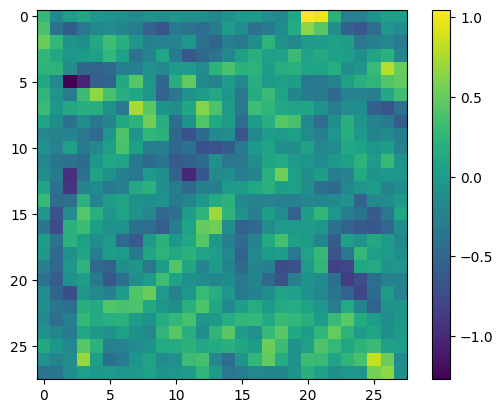

In [ ]:
import matplotlib.pyplot as plt
idx = 1
plt.imshow(output_feature_map['cnn_output'][0, idx].detach().cpu().numpy())
# Add a color bar
plt.colorbar()

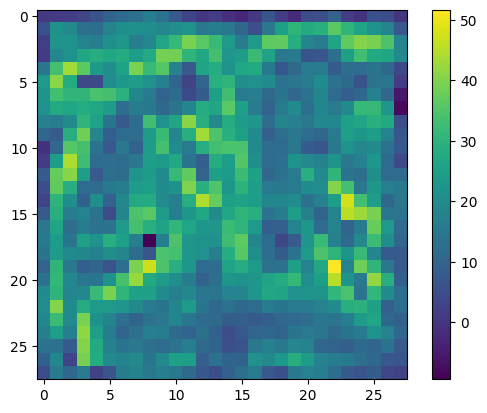

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(output_feature_map['cnn_output'][0].sum(0).detach().cpu().numpy())
# Add a color bar
plt.colorbar()

In [ ]:
 resnet18(weights=ResNet18_Weights.DEFAULT)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  